In [62]:
import mne
import pickle
from brainflow import BoardShim
from brainflow import BoardShim
from speller_config import *
from mne import create_info
import matplotlib.pyplot as plt
import numpy as np
from mne import time_frequency

### Stacking same class epochs and plotting stft

In [63]:
from glob import glob
import os
import numpy as np
import mne

def read_data(fpath):
    raw = mne.io.read_raw_fif(fpath, preload=True)
    x = raw.get_data()[:8, 250:1250]
    return np.expand_dims(x, axis=0)

files = glob(r'E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\*.fif')
# files = glob(r'E:\Thesis\HybridSpeller\three_flicker\record\sunsun_20230421_night\*.fif')
# files = glob(r'E:\Thesis\HybridSpeller\three_flicker\record\anagha_20230421\*.fif')
# files = glob(r'E:\Thesis\HybridSpeller\three_flicker\record\wan_20230421\*.fif')
data = {'A': [], 'B': [], 'C': []}

for fpath in files:
    filename = os.path.basename(fpath)
    group = filename[1]
    x = read_data(fpath)
    if group in data:
        data[group].append(x)

X_A = np.concatenate(data['A'])
X_B = np.concatenate(data['B'])
X_C = np.concatenate(data['C'])

print(X_A.shape, X_B.shape, X_C.shape)


Opening raw data file E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\0A.fif...
    Range : 0 ... 1755 =      0.000 ...     7.020 secs
Ready.
Reading 0 ... 1755  =      0.000 ...     7.020 secs...
Opening raw data file E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\0B.fif...
    Range : 0 ... 1756 =      0.000 ...     7.024 secs
Ready.
Reading 0 ... 1756  =      0.000 ...     7.024 secs...
Opening raw data file E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\0C.fif...
    Range : 0 ... 1752 =      0.000 ...     7.008 secs
Ready.
Reading 0 ... 1752  =      0.000 ...     7.008 secs...
Opening raw data file E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\0D.fif...
    Range : 0 ... 1752 =      0.000 ...     7.008 secs
Ready.
Reading 0 ... 1752  =      0.000 ...     7.008 secs...
Opening raw data file E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\1A.fif...
    Range : 0 ... 1757 =      0.000 ...     7.028 secs
Ready.
Reading 0 ... 1

C:\Users\Sunsun\AppData\Local\Temp\ipykernel_18004\1498488923.py:7: RuntimeWarning: This filename (E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\0A.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True)
C:\Users\Sunsun\AppData\Local\Temp\ipykernel_18004\1498488923.py:7: RuntimeWarning: This filename (E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\0B.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True)
C:\Users\Sunsun\AppData\Local\Temp\ipykernel_18004\1498488923.py:7: RuntimeWarning: This filename (E:\Thesis\HybridS

(5, 8, 1000) (5, 8, 1000) (5, 8, 1000)


In [64]:
stft_data = []
for i in range(X_C.shape[0]):
    stft = time_frequency.stft(X_C[i], wsize=252, verbose=False); 
    stft_data.append(np.expand_dims(stft, axis=0))
stft_data = np.concatenate(stft_data, axis=0)
stft_data.shape

(5, 8, 127, 8)

(5, 8, 127, 8)
(45, 8)


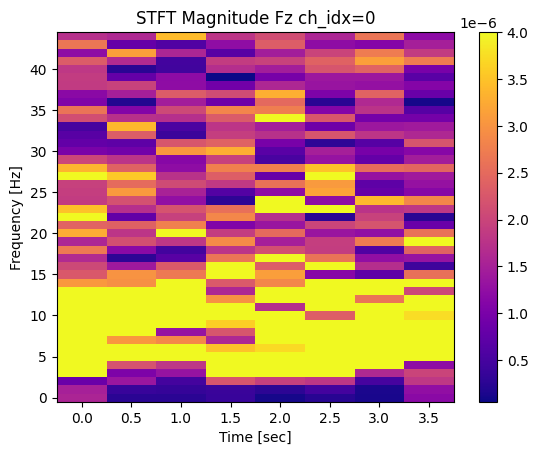

(5, 8, 127, 8)
(45, 8)


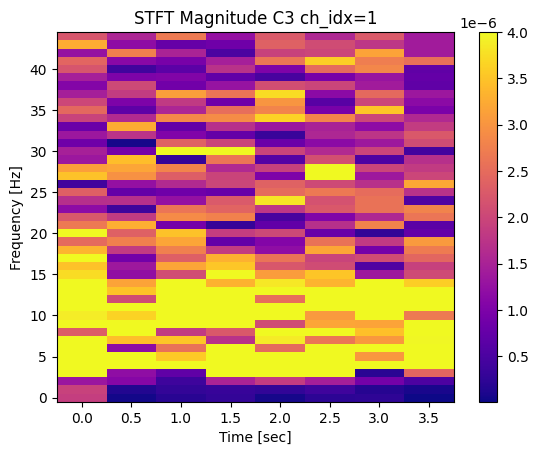

(5, 8, 127, 8)
(45, 8)


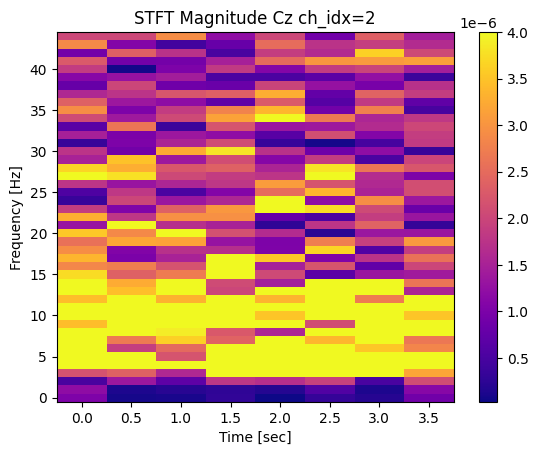

(5, 8, 127, 8)
(45, 8)


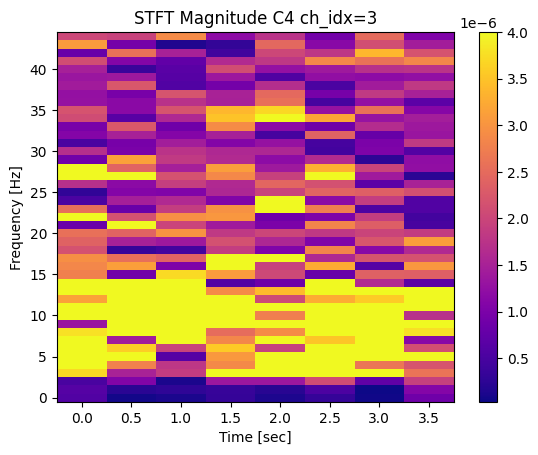

(5, 8, 127, 8)
(45, 8)


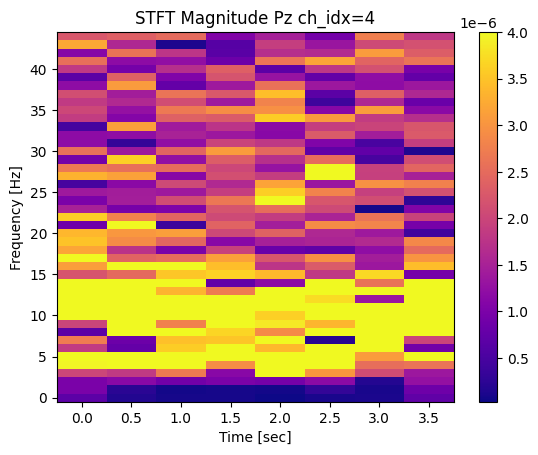

(5, 8, 127, 8)
(45, 8)


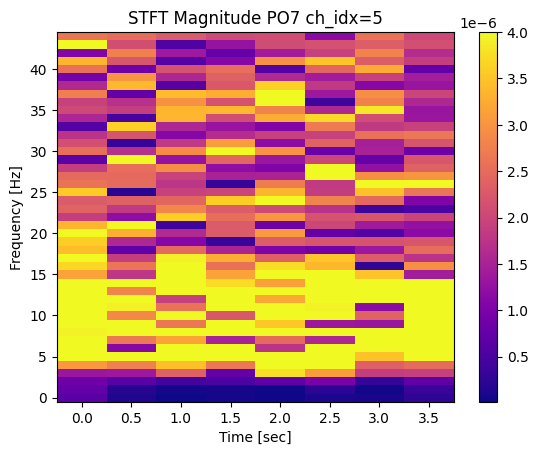

(5, 8, 127, 8)
(45, 8)


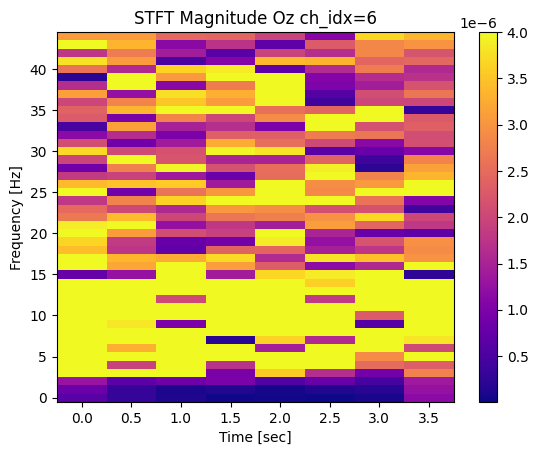

(5, 8, 127, 8)
(45, 8)


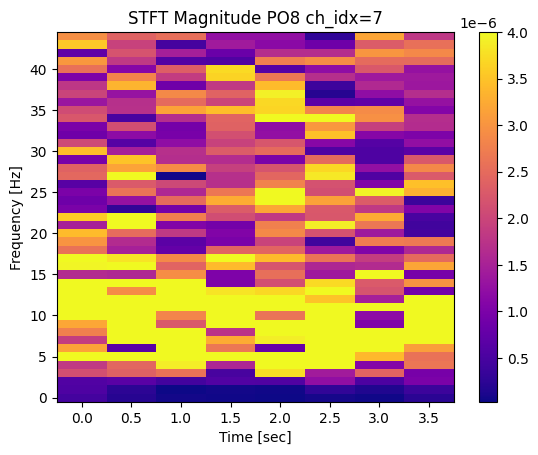

In [65]:
ch_names = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8', 'STIM MARKERS']

for ch_idx in range(0,8):
    X = stft_data
    X = X[:20]
    print(X.shape)
    # X = abs(X)
    X = X.mean(axis=0)
    X = X[ch_idx]
    X = X[:45,:]
    print(X.shape)

    c = plt.pcolormesh(np.arange(0,(X.shape[1]) //2,0.5), range(X.shape[0]), np.abs(X), cmap='plasma', vmax=4e-6)
    plt.colorbar(c)
    plt.title(f'STFT Magnitude {ch_names[ch_idx]} {ch_idx=}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

### Plotting stft for each epoch

Opening raw data file E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\0A.fif...
    Range : 0 ... 1755 =      0.000 ...     7.020 secs
Ready.
Reading 0 ... 1755  =      0.000 ...     7.020 secs...


C:\Users\Sunsun\AppData\Local\Temp\ipykernel_18004\711976384.py:3: RuntimeWarning: This filename (E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\0A.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw =  mne.io.read_raw_fif(fname,  preload = True)


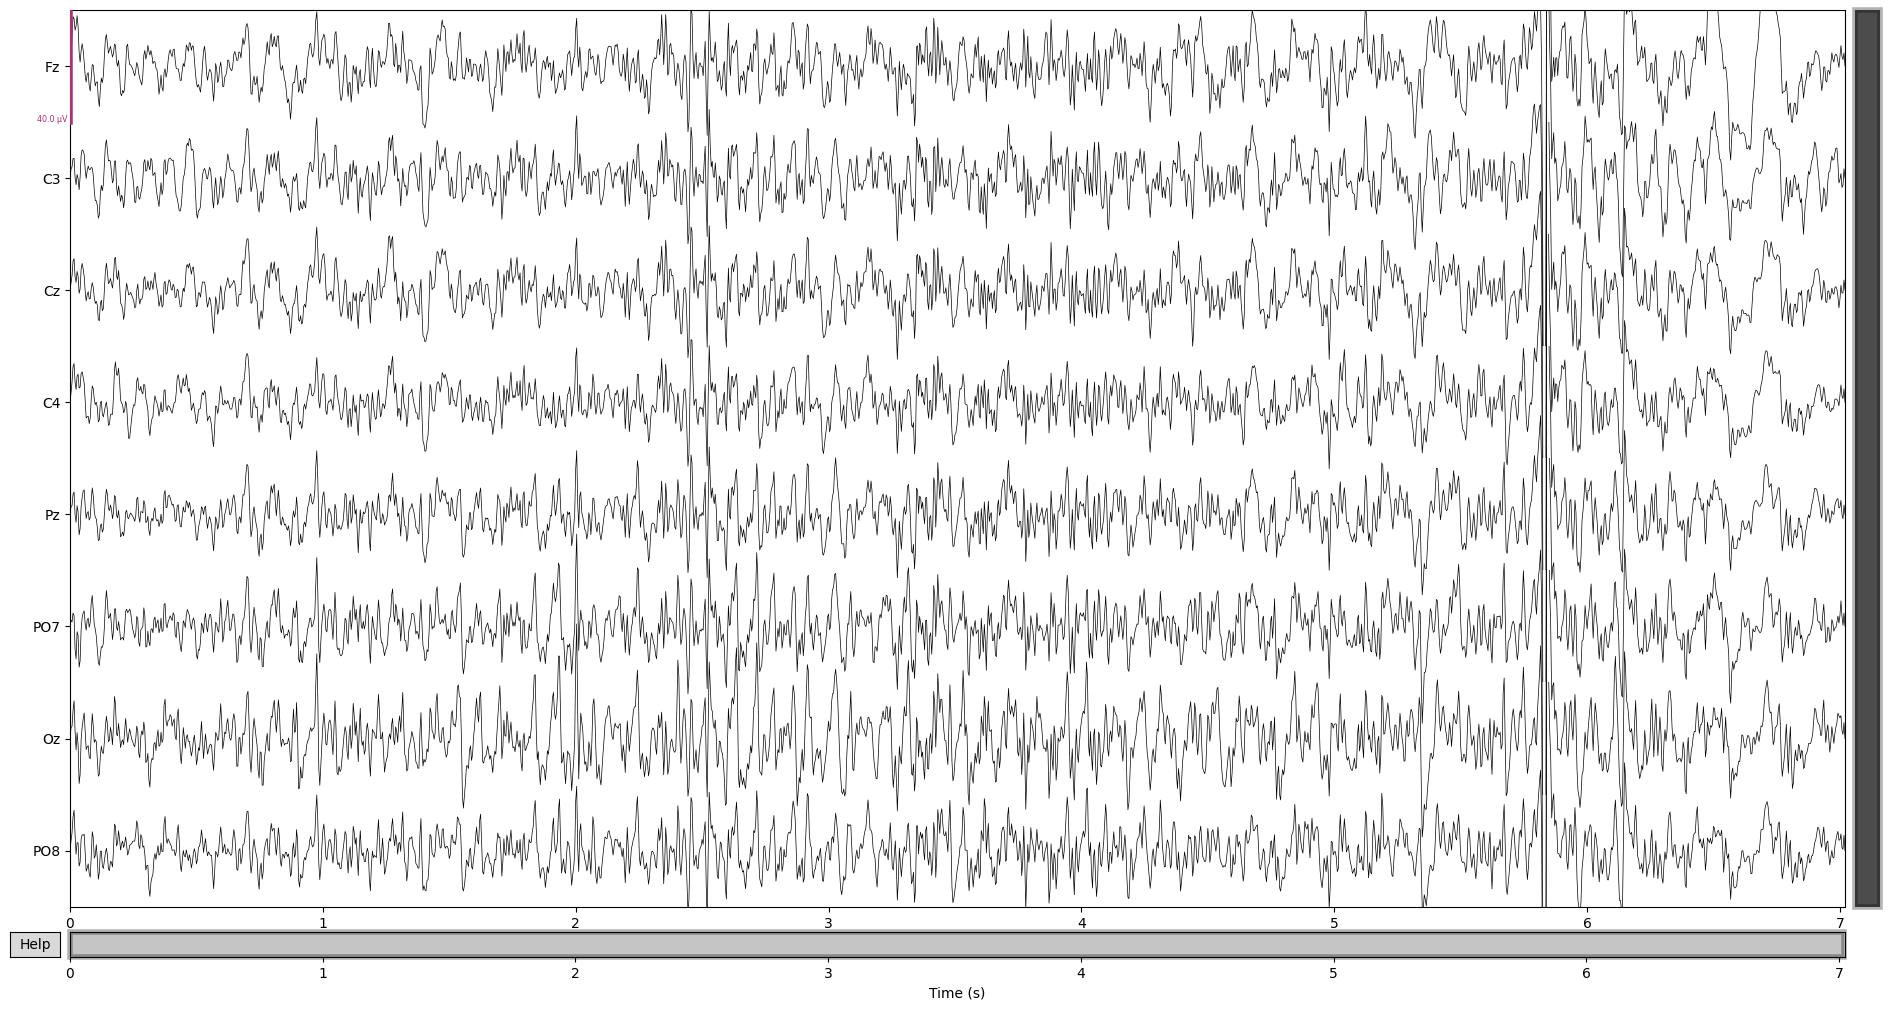

Creating RawArray with float64 data, n_channels=8, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.


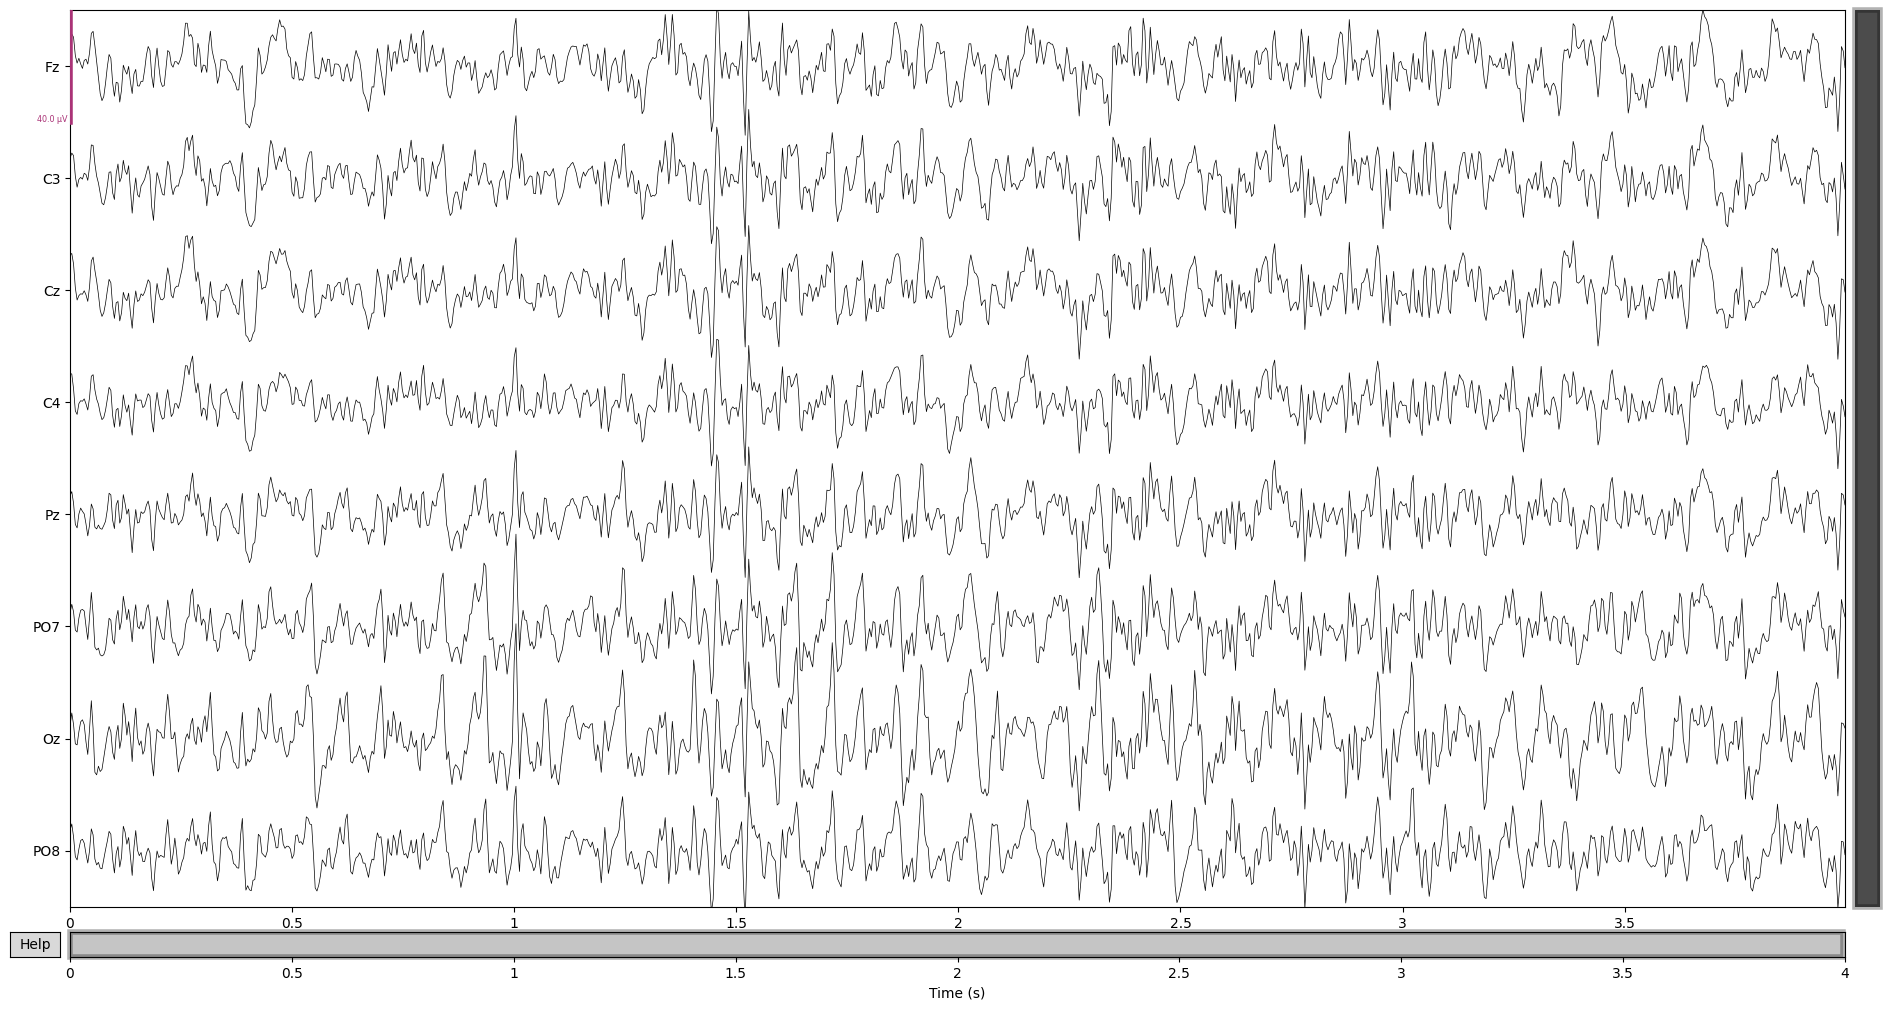

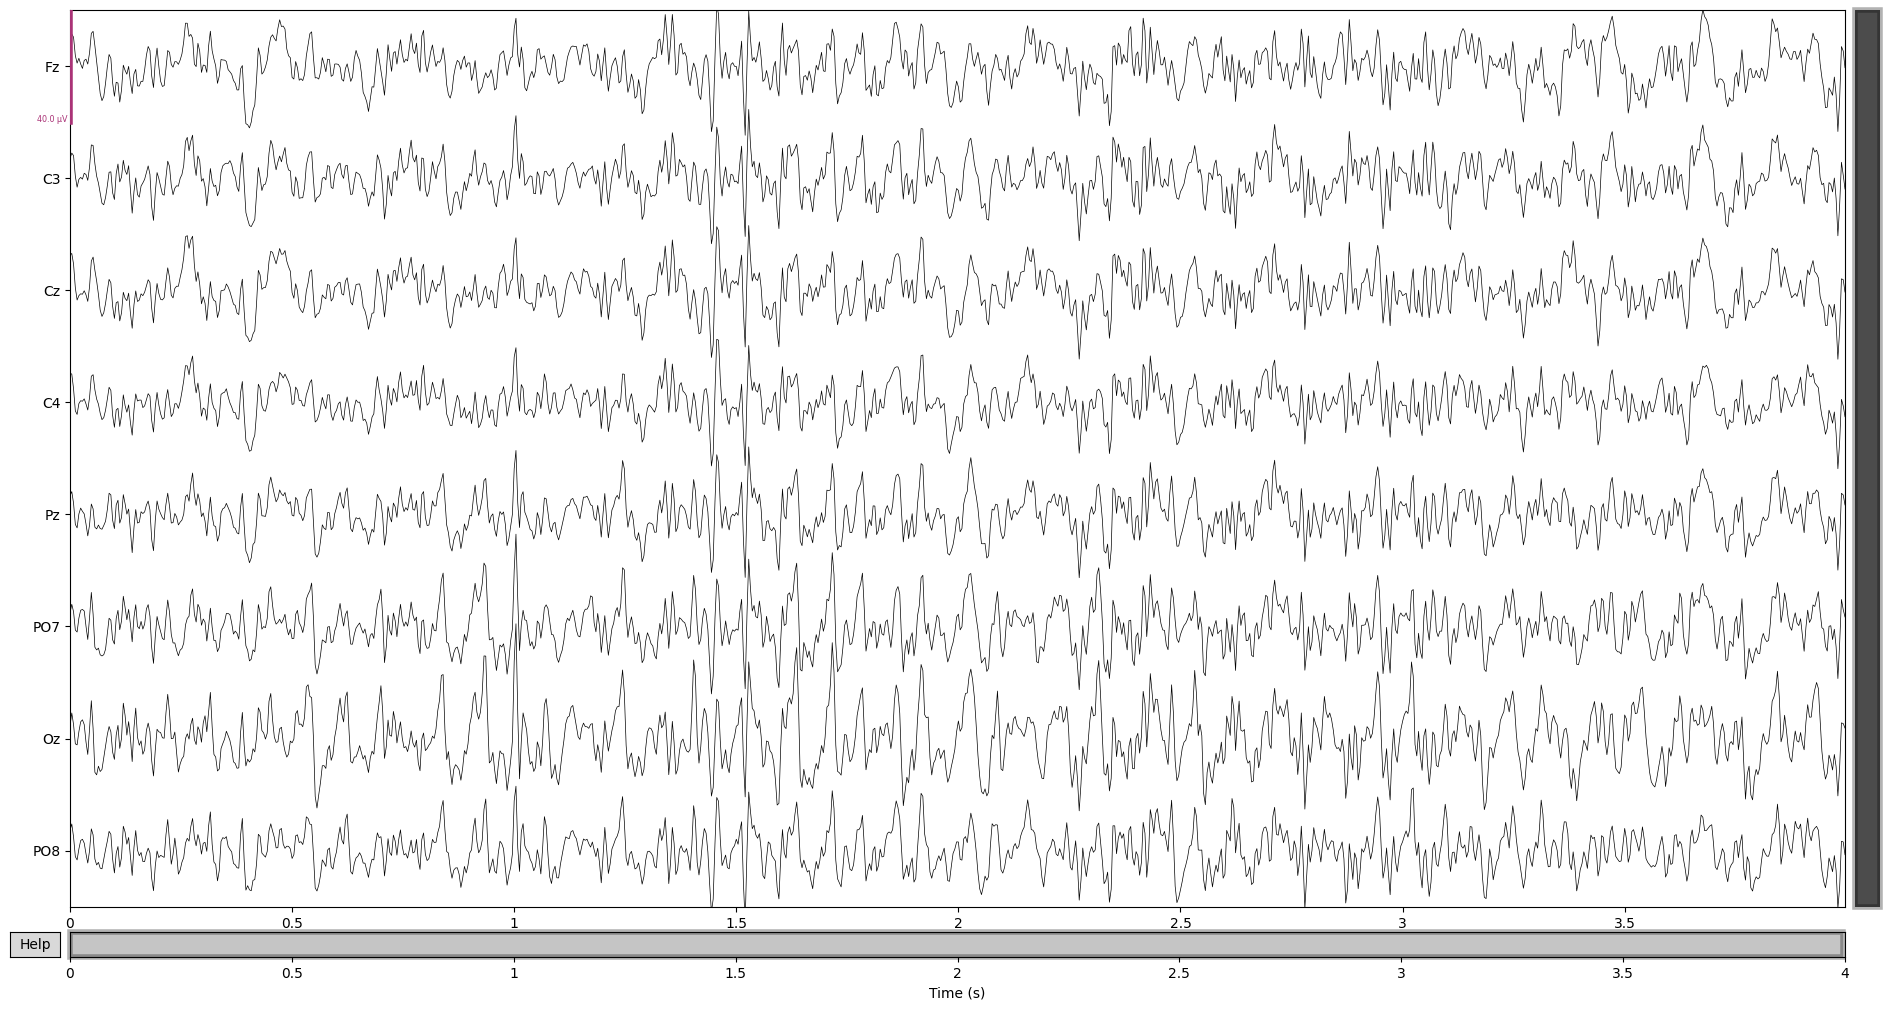

In [66]:
fname = r'E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\0A.fif'

raw =  mne.io.read_raw_fif(fname,  preload = True)
raw.plot()
data = raw.get_data()[:8,250:1250]
new_raw = mne.io.RawArray(data,raw.info)
new_raw.plot()

In [67]:
stft_data = []
data = np.expand_dims(data,axis=0)
print(data.shape)
for i in range(data.shape[0]):
    stft = time_frequency.stft(data[i], wsize=252, verbose=False); 
    stft_data.append(np.expand_dims(stft, axis=0))
stft_data = np.concatenate(stft_data, axis=0)
stft_data.shape

(1, 8, 1000)


(1, 8, 127, 8)

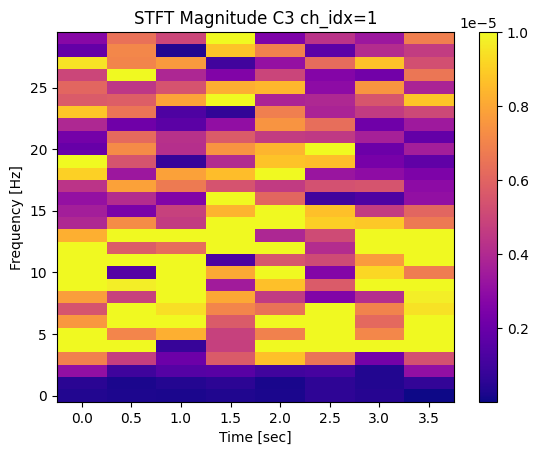

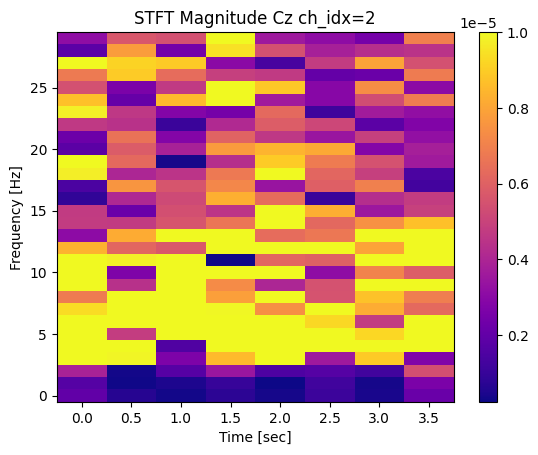

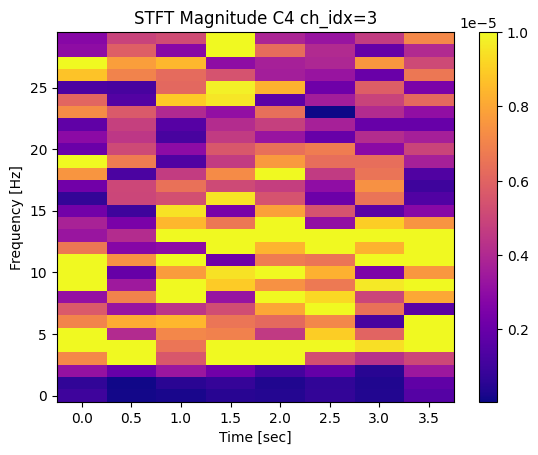

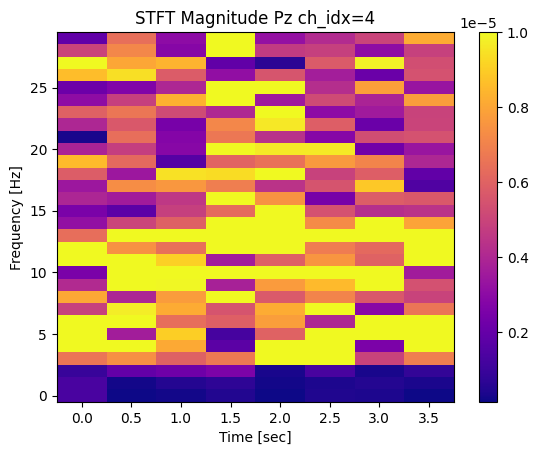

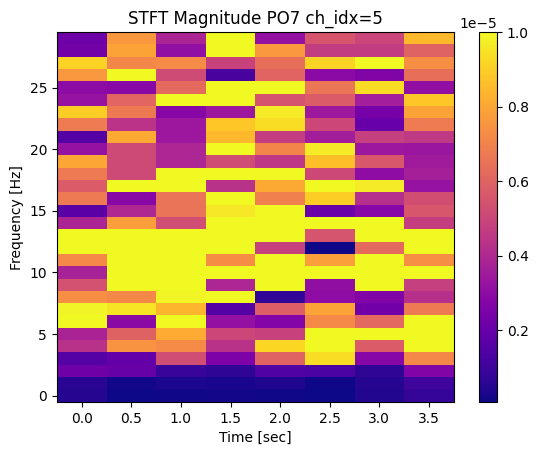

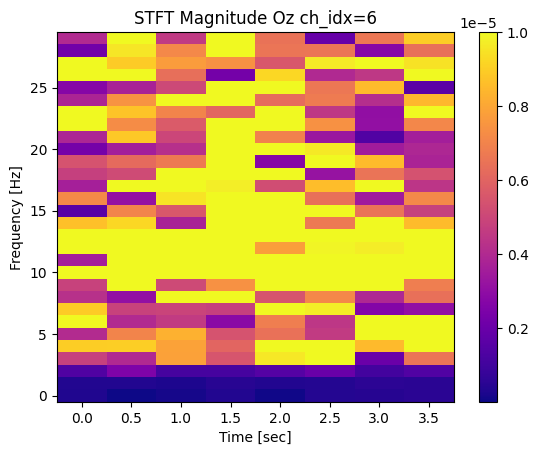

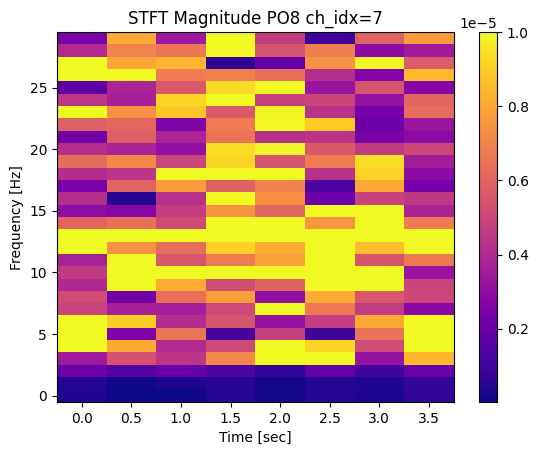

In [68]:
for ch_idx in range(1,8):
    stft = stft_data[0,ch_idx]
    stft = stft[:30,:]
    c = plt.pcolormesh(np.arange(0,(stft.shape[1]) //2,0.5), range(stft.shape[0]), np.abs(stft), cmap='plasma', vmax=10e-6)
    plt.colorbar(c)
    plt.title(f'STFT Magnitude {raw.ch_names[ch_idx]} {ch_idx=}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

In [69]:
from numpy import ndarray
import numpy as np
from scipy.sparse import vstack, identity, spmatrix
from typing import Optional, cast, Union
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
from scipy.stats import pearsonr
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from joblib import Parallel, delayed
from functools import partial



def _ged_wong(
    Z: ndarray,
    D: Optional[ndarray] = None,
    P: Optional[ndarray] = None,
    n_components=1,
    method="type1",
):
    if method != "type1" and method != "type2":
        raise ValueError("not supported method type")

    A = Z
    if D is not None:
        A = D.T @ A
    if P is not None:
        A = P.T @ A
    A = A.T @ A
    if method == "type1":
        B = Z
        if D is not None:
            B = D.T @ Z
        B = B.T @ B
        if isinstance(A, spmatrix) or isinstance(B, spmatrix):
            D, W = eigsh(A, k=n_components, M=B)
        else:
            D, W = eigh(A, B)
    elif method == "type2":
        if isinstance(A, spmatrix):
            D, W = eigsh(A, k=n_components)
        else:
            D, W = eigh(A)

    D_exist = cast(ndarray, D)
    ind = np.argsort(D_exist)[::-1]
    D_exist, W = D_exist[ind], W[:, ind]
    return D_exist[:n_components], W[:, :n_components]


def _trca_kernel(X: ndarray):
    """TRCA.
    X: (n_trials, n_channels, n_samples)
    """
    X = np.reshape(X, (-1, *X.shape[-2:]))
    M, C, N = X.shape
    n_components = C
    P = vstack([identity(N) for _ in range(M)])
    P = P @ P.T
    # P = abs(P @ P.T)
    Z = np.hstack(X).T  # type: ignore
    _, U = _ged_wong(Z, None, P, n_components=n_components)  # U for X
    return U


def _trca_feature(
    X: ndarray,
    templates: ndarray,
    Us: ndarray,
    n_components: int = 1,
    ensemble: bool = True,
):
    rhos = []
    if not ensemble:
        for Xk, U in zip(templates, Us):
            a = U[:, :n_components].T @ X
            b = U[:, :n_components].T @ Xk
            a = np.reshape(a, (-1))
            b = np.reshape(b, (-1))
            rhos.append(pearsonr(a, b)[0])
    else:
        U = Us[:, :, :n_components]
        U = np.concatenate(U, axis=-1)
        for Xk in templates:
            a = U.T @ X
            b = U.T @ Xk
            a = np.reshape(a, (-1))
            b = np.reshape(b, (-1))
            rhos.append(pearsonr(a, b)[0])
    return rhos


class TRCA(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(
        self, n_components: int = 1, ensemble: bool = True, n_jobs: Optional[int] = None
    ):
        self.n_components = n_components
        self.ensemble = ensemble
        self.n_jobs = n_jobs

    def fit(self, X: ndarray, y: ndarray, Yf: Optional[ndarray] = None):
        self.classes_ = np.unique(y)
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        self.templates_ = np.stack(
            [np.mean(X[y == label], axis=0) for label in self.classes_]
        )

        self.Us_ = np.stack([_trca_kernel(X[y == label]) for label in self.classes_])
        return self

    def transform(self, X: ndarray):
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        n_components = self.n_components
        templates = self.templates_
        Us = self.Us_
        ensemble = self.ensemble
        rhos = Parallel(n_jobs=self.n_jobs)(
            delayed(
                partial(
                    _trca_feature, Us=Us, n_components=n_components, ensemble=ensemble
                )
            )(a, templates)
            for a in X
        )
        rhos = np.stack(rhos)
        return rhos

    def predict(self, X: ndarray):
        feat = self.transform(X)
        labels = self.classes_[np.argmax(feat, axis=-1)]
        return labels


def generate_cca_references(
    freqs,
    srate,
    T,
    phases: Optional[Union[ndarray, int, float]] = None,
    n_harmonics: int = 1,
):
    if isinstance(freqs, int) or isinstance(freqs, float):
        freqs = [freqs]
    freqs = np.array(freqs)[:, np.newaxis]
    if phases is None:
        phases = 0
    if isinstance(phases, int) or isinstance(phases, float):
        phases = np.array([phases])
    phases = np.array(phases)[:, np.newaxis]
    t = np.linspace(0, T, int(T * srate))

    Yf = []
    for i in range(n_harmonics):
        Yf.append(
            np.stack(
                [
                    np.sin(2 * np.pi * (i + 1) * freqs * t + np.pi * phases),
                    np.cos(2 * np.pi * (i + 1) * freqs * t + np.pi * phases),
                ],
                axis=1,
            )
        )
    Yf = np.concatenate(Yf, axis=1)
    return Yf

### Passing all epoch in loop to TRCA

In [70]:
from glob import glob
import os
files = glob(r'E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\*.fif')
# files = glob(r'E:\Thesis\HybridSpeller\three_flicker\record\wan_20230421\*.fif')
# files = glob(r'E:\Thesis\HybridSpeller\three_flicker\record\anagha_20230421\*.fif')
y = []
X = []
for fpath in files:
    _,filename = os.path.split(fpath)
    y.append(filename[1])

    raw =  mne.io.read_raw_fif(fpath,  preload = True)
    x = raw.get_data()[:8,250:1250]
    X.append(np.expand_dims(x,axis=0))

y = np.array(y)
X = np.concatenate(X)

print(X.shape, y.shape)

# fname = r'E:\Thesis\HybridSpeller\three_flicker\record\sunsun_20230420\2C.fif'

# raw =  mne.io.read_raw_fif(fname,  preload = True)
# raw.plot()
# data = raw.get_data()[:8,250:1250]
# new_raw = mne.io.RawArray(data,raw.info)
# new_raw.plot()

Opening raw data file E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\0A.fif...
    Range : 0 ... 1755 =      0.000 ...     7.020 secs
Ready.
Reading 0 ... 1755  =      0.000 ...     7.020 secs...
Opening raw data file E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\0B.fif...
    Range : 0 ... 1756 =      0.000 ...     7.024 secs
Ready.
Reading 0 ... 1756  =      0.000 ...     7.024 secs...
Opening raw data file E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\0C.fif...
    Range : 0 ... 1752 =      0.000 ...     7.008 secs
Ready.
Reading 0 ... 1752  =      0.000 ...     7.008 secs...
Opening raw data file E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\0D.fif...
    Range : 0 ... 1752 =      0.000 ...     7.008 secs
Ready.
Reading 0 ... 1752  =      0.000 ...     7.008 secs...
Opening raw data file E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\1A.fif...
    Range : 0 ... 1757 =      0.000 ...     7.028 secs
Ready.
Reading 0 ... 1

C:\Users\Sunsun\AppData\Local\Temp\ipykernel_18004\4157716558.py:12: RuntimeWarning: This filename (E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\0A.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw =  mne.io.read_raw_fif(fpath,  preload = True)
C:\Users\Sunsun\AppData\Local\Temp\ipykernel_18004\4157716558.py:12: RuntimeWarning: This filename (E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\0B.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw =  mne.io.read_raw_fif(fpath,  preload = True)
C:\Users\Sunsun\AppData\Local\Temp\ipykernel_18004\4157716558.py:12: RuntimeWarning: This filename (E:\The

Reading 0 ... 1753  =      0.000 ...     7.012 secs...
Opening raw data file E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\anuj_20230425.fif...
    Range : 0 ... 142949 =      0.000 ...   571.796 secs
Ready.
Reading 0 ... 142949  =      0.000 ...   571.796 secs...
(21, 8, 1000) (21,)


C:\Users\Sunsun\AppData\Local\Temp\ipykernel_18004\4157716558.py:12: RuntimeWarning: This filename (E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\anuj_20230425.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw =  mne.io.read_raw_fif(fpath,  preload = True)


In [71]:
print(X.shape, y.shape)
loaded_model = pickle.load(open(r"E:\Thesis\HybridSpeller\three_flicker\TRCA_model.sav", 'rb'))

(21, 8, 1000) (21,)


In [72]:
preds = loaded_model.predict(X)

In [73]:
print(preds)
print(y)


[1 2 4 1 1 2 3 3 1 4 4 2 1 3 4 1 1 2 1 1 4]
['A' 'B' 'C' 'D' 'A' 'B' 'C' 'D' 'A' 'B' 'C' 'D' 'A' 'B' 'C' 'D' 'A' 'B'
 'C' 'D' 'n']


In [74]:
c = 0
for idx in range(len(preds)):
    pred = preds[idx]
    label = y[idx]
    if(pred == 1):
        pred = 'A'
    if(pred == 2):
        pred = 'B'
    if(pred == 3):
        pred = 'C'
    if(pred == 4):
        pred = 'D'
    if(label == pred):
        c += 1

acc = c/21
print(acc)

0.42857142857142855


### Passing each pickle file into TRCA

In [75]:
from glob import glob
import os
from scipy import signal

pickle_files = glob(r'E:\Thesis\HybridSpeller\three_flicker\record\anuj_20230425\*.pickle')
# pickle_files = glob(r'E:\Thesis\HybridSpeller\three_flicker\record\wan_20230421\*.pickle')
# pickle_files = glob(r'E:\Thesis\HybridSpeller\three_flicker\record\anagha_20230421\*.pickle')
y_pickle = []
X_pickle = []
for fpath in pickle_files:
    _,filename = os.path.split(fpath)
    y_pickle.append(filename[1])

    with open(fpath, 'rb') as handle:
        pickle_data = pickle.load(handle)

    marker_channel = BoardShim.get_marker_channel(BOARD_ID)
    eeg_channels = BoardShim.get_eeg_channels(BOARD_ID)
    pickle_data[eeg_channels] = pickle_data[eeg_channels] / 1e6
    pickle_data = pickle_data[eeg_channels + [marker_channel]]

    _CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
    data = pickle_data[:8,:1740] # pickle-sunsun_20230420_night
    # data = pickle_data[:8,:1450]
    print(data.shape)
    
    order = 1
    l_freq = 4
    sos = signal.butter(order, l_freq, 'highpass', analog=False, fs=250, output='sos')
    notch_freq = 50
    quality = 1
    b,a = signal.iirnotch(notch_freq, quality, fs=250)
    for i in range(8):
        data[i] = signal.lfilter(b, a, data[i])
        data[i] = signal.sosfilt(sos, data[i])
    X_pickle.append(np.expand_dims(data[:],axis=0))
    # ch_names = [ch_name.upper() for ch_name in _CHANNELS]
    # ch_names = ch_names + ['STIM']
    # ch_types = ["eeg"] * 9
    # ch_types[-1] = "stim"

    # info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=250)
    # raw_pickle = mne.io.RawArray(pickle_data, info=info)
    # raw_pickle.notch_filter([50])
    # raw_pickle.filter(4,77)
    # x = raw_pickle.get_data()[:8,250:1250]
    # X_pickle.append(np.expand_dims(x,axis=0))

y_pickle = np.array(y_pickle)
X_pickle = np.concatenate(X_pickle)

print(X_pickle.shape, y_pickle.shape)

(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(8, 1740)
(20, 8, 1740) (20,)


In [76]:
X_A = X_pickle[y_pickle=='A']
X_B = X_pickle[y_pickle=='B']
X_C = X_pickle[y_pickle=='C']
X_A.shape, X_B.shape, X_C.shape

((5, 8, 1740), (5, 8, 1740), (5, 8, 1740))

In [77]:
stft_data = []
for i in range(X_A.shape[0]):
    stft = time_frequency.stft(X_A[i], wsize=252, verbose=False); 
    stft_data.append(np.expand_dims(stft, axis=0))
stft_data = np.concatenate(stft_data, axis=0)
stft_data.shape

(5, 8, 127, 14)

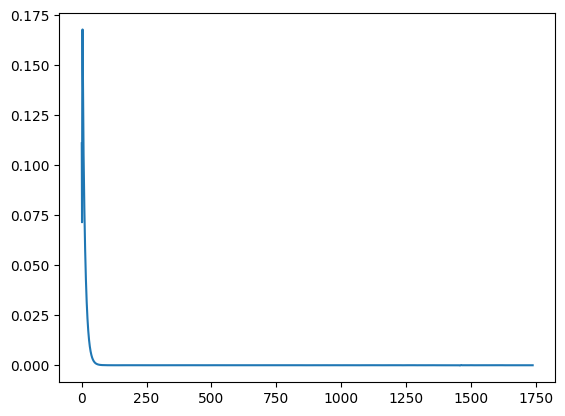

In [78]:
plt.plot(X_A[0,0,])
plt.show()

(8, 127, 14)
(45, 14)


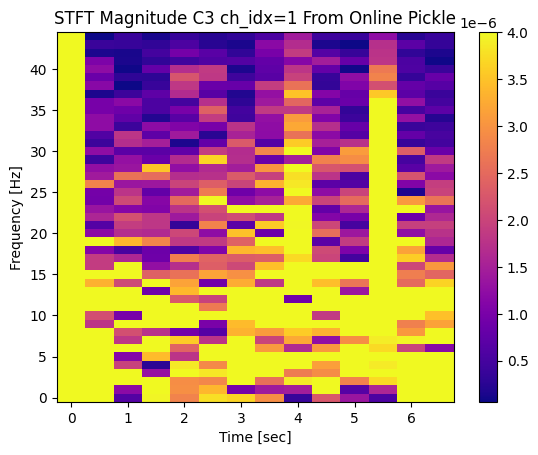

(8, 127, 14)
(45, 14)


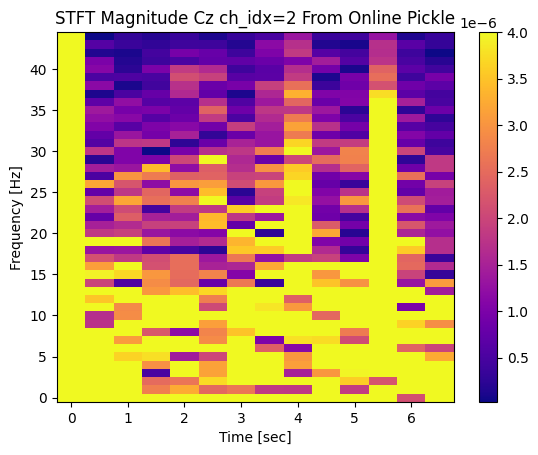

(8, 127, 14)
(45, 14)


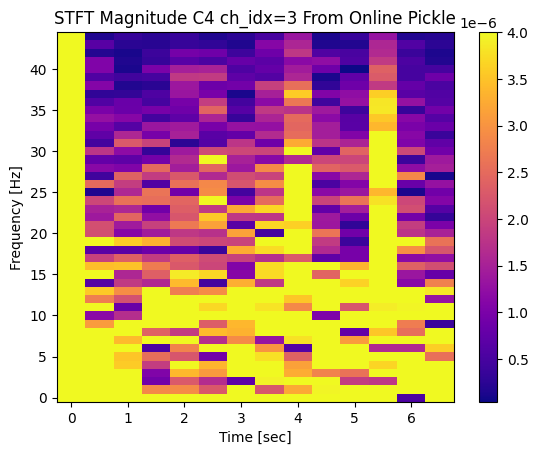

(8, 127, 14)
(45, 14)


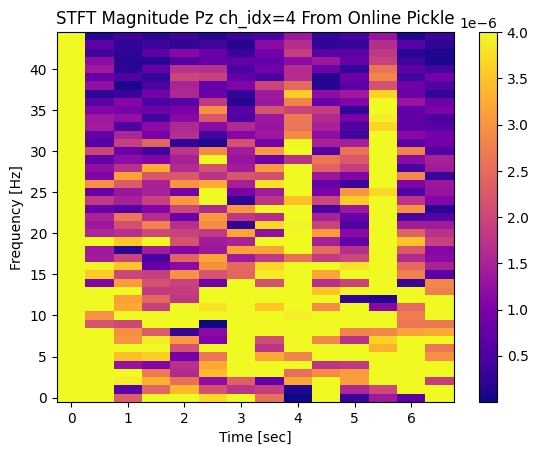

(8, 127, 14)
(45, 14)


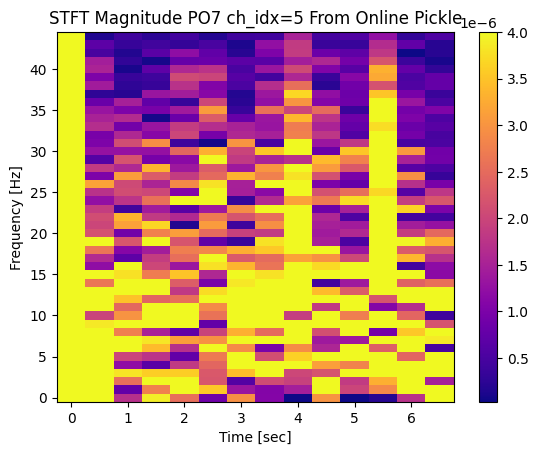

(8, 127, 14)
(45, 14)


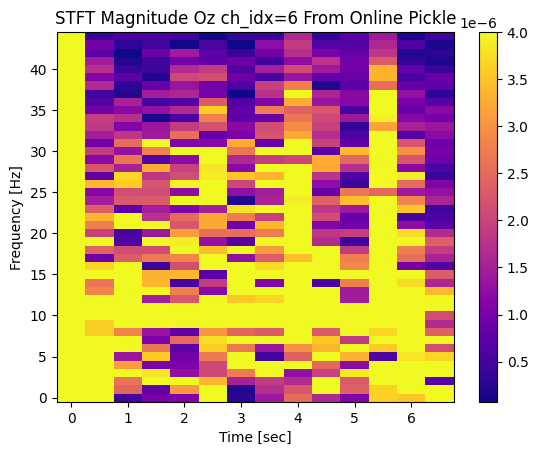

(8, 127, 14)
(45, 14)


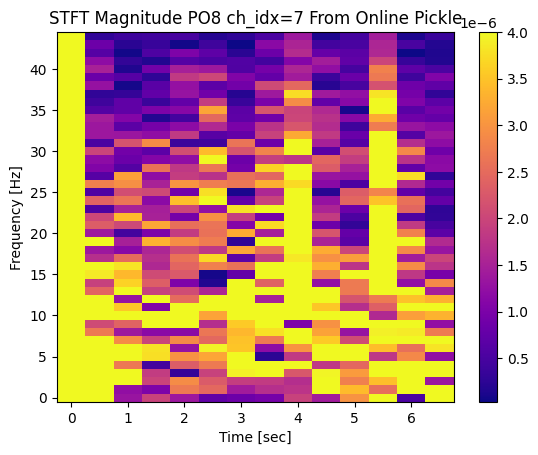

In [79]:
for ch_idx in range(1,8):
    X = stft_data
    # X = abs(X)
    X = X.mean(axis=0)
    print(X.shape)
    X = X[ch_idx]
    X = X[:45,:]
    # X[0,:] = 0
    # X[1,:] = 0
    # X[2,:] = 0
    # X[3,:] = 0
    # X[4,:] = 0
    # X[5,:] = 0
    # X[:,0] = 0
    # X[:,-1] = 0
    print(X.shape)

    c = plt.pcolormesh(np.arange(0,(X.shape[1]) //2,0.5), range(X.shape[0]), np.abs(X), cmap='plasma', vmax=4e-6)
    plt.colorbar(c)
    plt.title(f'STFT Magnitude {raw.ch_names[ch_idx]} {ch_idx=} From Online Pickle')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

In [80]:
offset = int(250 * 1.5)
preds_pickle = loaded_model.predict(X_pickle[:,:,offset:offset + 1000])
# print(preds_pickle)
# print(y_pickle)
c = 0
for idx in range(len(preds_pickle)):
    pred = preds_pickle[idx]
    label = y_pickle[idx]
    if(pred == 1):
        pred = 'A'
    if(pred == 2):
        pred = 'B'
    if(pred == 3):
        pred = 'C'
    if(pred == 4):
        pred = 'D'
    if(label == pred):
        c += 1
    print(idx, f"{pred=} {label=}" )
print(c/20
      )

0 pred='A' label='A'
1 pred='B' label='B'
2 pred='C' label='C'
3 pred='D' label='D'
4 pred='A' label='A'
5 pred='B' label='B'
6 pred='A' label='C'
7 pred='D' label='D'
8 pred='A' label='A'
9 pred='D' label='B'
10 pred='C' label='C'
11 pred='D' label='D'
12 pred='A' label='A'
13 pred='A' label='B'
14 pred='C' label='C'
15 pred='D' label='D'
16 pred='A' label='A'
17 pred='B' label='B'
18 pred='C' label='C'
19 pred='A' label='D'
0.8


### Passing one pickle file into TRCA

In [81]:
pickle_filename = r'C:\Users\bci\Documents\projects\hybrid-ssvep-p300-speller\three_flicker\record\sunsun_20230423\0B.pickle'

with open(pickle_filename, 'rb') as handle:
    pickle_data = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\bci\\Documents\\projects\\hybrid-ssvep-p300-speller\\three_flicker\\record\\sunsun_20230423\\0B.pickle'

In [ ]:
marker_channel = BoardShim.get_marker_channel(BOARD_ID)
eeg_channels = BoardShim.get_eeg_channels(BOARD_ID)
pickle_data[eeg_channels] = pickle_data[eeg_channels] / 1e6
pickle_data = pickle_data[eeg_channels + [marker_channel]]

# for i in range(9):
#     plt.plot(pickle_data[i,-500:])
#     plt.show()

In [ ]:
_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
ch_names = [ch_name.upper() for ch_name in _CHANNELS]
ch_names = ch_names + ['STIM']
ch_types = ["eeg"] * 9
ch_types[-1] = "stim"

info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=250)

In [ ]:
raw_pickle = mne.io.RawArray(pickle_data, info=info)
raw_pickle.notch_filter([50])
raw_pickle.filter(4,77)
raw_pickle.plot()

In [ ]:
data = raw_pickle.get_data()[:8,250:1250]

In [ ]:
pred = loaded_model.predict(data)
print(pred)